In [97]:
from databaseCommunication import getNCount
from dataframeFormating import createLabeledDataFrame, fitRun_1and3b, fitRun_3b, getReducedDataframe, getReducedResults, deltaTime, N_polarized, N_polarized_pure3b, fit_powerlaw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

#getNCount(94000)

In [98]:
# [detuning, field direction], [imageID_start, imageID_end]
labels = [[['1.5V', 'Bz', 7], [97472, 97571]],
          [['1.5V', 'By', 7], [97573, 97672]]
         ]
excluded = []

In [20]:
#df = createLabeledDataFrame(labels)
#df['BECHoldTime'] = df['BECHoldTime'].astype(float)
#df.to_pickle('data_save_100321_2.pickle')

In [99]:
df = pd.read_pickle('data_save_100321_2.pickle')

# Delete these row indexes from dataFrame
indexNames = pd.Index(np.where(df['imageID'].isin(excluded))[0])
df.drop(indexNames, inplace = True)
df

,imageID,BECHoldTime,TOF,nCount,detuning,field_direction
0,97472.0,20.0,7,160894.0,1.5V,Bz
1,97473.0,8.0,7,185303.0,1.5V,Bz
2,97474.0,15.0,7,177657.0,1.5V,Bz
3,97475.0,170.0,7,116548.0,1.5V,Bz
4,97476.0,700.0,7,29780.0,1.5V,Bz
...,...,...,...,...,...,...
195,97668.0,10.0,7,153563.0,1.5V,By
196,97669.0,90.0,7,84643.0,1.5V,By
197,97670.0,500.0,7,21862.0,1.5V,By
198,97671.0,120.0,7,57348.0,1.5V,By


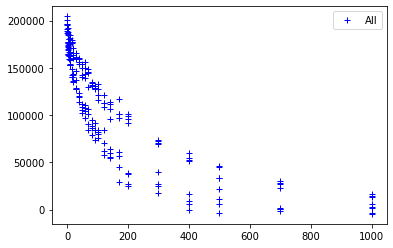

In [100]:
plt.figure()
plt.plot(df['BECHoldTime'], df['nCount'], '+', color = 'blue', label = 'All')
plt.legend()
plt.show()

#run = df[df['detuning'] == '0.5GHz']
#run1 = run[run['field_direction'] == 'Bz']
#run2 = run[run['field_direction'] == 'By']
#plt.figure()
#plt.plot(run1['BECHoldTime'], run1['nCount'], '+', color = 'blue', label = 'Bz')
#plt.plot(run2['BECHoldTime'], run2['nCount'], '+', color = 'red', label = 'By')
#plt.legend()
#plt.show()

We fit the polarized sample to $dN/dt = -\alpha N-\gamma N^{3}$, so $N(t) = \frac{\sqrt{\alpha}}{\sqrt{e^{2\alpha t}\left(\frac{a}{N(0)^{2}}+\gamma\right)-\gamma}}$ and the mixture one to $dN/dt = -\alpha N - \beta N^{2} -\gamma N^{3}$, so $N(t) = complicated$

In [101]:
results = []
for run in labels:
    detuning, field_direction, TOF = run[0]
    print(detuning, field_direction, TOF)
    popt, pcov = fitRun_1and3b(df, detuning, field_direction, TOF)
    results += [{'detuning' : detuning,
                        'TOF' : TOF,
                        'field_direction' : field_direction,
                        'N0' : popt[0],
                        'alpha' : popt[1],
                        'gamma' : popt[2]}]
resultsDF = pd.DataFrame(results)
print('\n')
print(resultsDF)
print('\n')
print(resultsDF['alpha']*resultsDF['N0']/(resultsDF['gamma']*(resultsDF['N0']**3)))
#perr = np.sqrt(np.diag(pcov))

1.5V Bz 7
1.5V By 7


  detuning  TOF field_direction             N0     alpha         gamma
0     1.5V    7              Bz  184780.566839  0.002309  6.808619e-14
1     1.5V    7              By  179032.208275  0.005399  2.326350e-13


0    0.993078
1    0.724066
dtype: float64


We notice the decay is nearly 3-body in all case. To ensure that we can look at $\alpha N_{0}/(\gamma*N_{0}^{3})$ which at $t=0$ is never above a 10\%. So let's just fit to a 3body decay curve.
$dN/dt = -\gamma N^{3}$, so $N(t) = \frac{N_{0}}{\sqrt{1+N_{0}^{2}\gamma t}}$.

In [102]:
results = []

for run in labels:
    detuning, field_direction, TOF = run[0]
    popt, pcov = fitRun_3b(df, detuning, field_direction, TOF)
    results += [{'detuning' : detuning,
                        'TOF' : TOF,
                        'field_direction' : field_direction,
                        'N0' : popt[0],
                        'gamma' : popt[1]}]
resultsDF_pure3b = pd.DataFrame(results)
resultsDF_pure3b
#perr = np.sqrt(np.diag(pcov))

,detuning,TOF,field_direction,N0,gamma
0,1.5V,7,Bz,192757.300155,4.617410e-13
1,1.5V,7,By,192724.781136,1.568246e-12


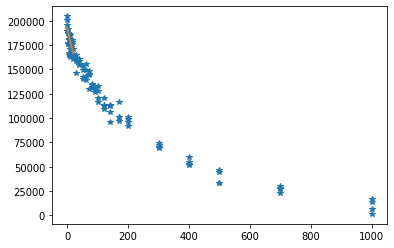

In [103]:
df_reduced = getReducedDataframe(df, detuning = '1.5V', field_direction = 'Bz', TOF = 7)
result_reduced = getReducedResults(resultsDF_pure3b, detuning = '1.5V', field_direction = 'Bz', TOF = 7)
holdTime = np.linspace(0,20, 300)
plt.figure()
plt.plot(df_reduced['BECHoldTime'], df_reduced['nCount'], '*')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced['N0'][0], result_reduced['gamma'][0]))
plt.show()

Now we should look at how much time we should shift:

In [104]:
deltaTime(resultsDF_pure3b, '1.5V', 7)

0.020002000200020003

Now we can calculate the ration of the beta, provided the derivative of the N_polarized_pure3b function: $\frac{dN}{dt} = -\frac{1}{2}N_{0}^{3}\gamma\left(1+N_{0}^{2}\gamma t\right)^{-3/2}$

In [105]:
def dN_polarized_pure3b_dt(t, N0, gamma):
    return -0.5*N0**3*gamma*(1+N0**2*gamma*t)**(-3/2)

def getBeta(results, detuning, field_direction, TOF):
    temp = results[results['detuning'] == detuning]
    temp = temp[temp['TOF'] == TOF]
    return temp[temp['field_direction'] == field_direction]['gamma']

results_betaRatio = []
for detuning in ['1.5V']:
    for TOF in [7]:
        print(detuning, TOF)
        beta_y_init = getBeta(resultsDF_pure3b, detuning, 'By', TOF)
        beta_z_init = getBeta(resultsDF_pure3b, detuning, 'Bz', TOF)
        #dt = deltaTime(resultsDF_pure3b, detuning, TOF)
        
        results_By = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)
        results_Bz = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
        N0_y, gamma_y = results_By['N0'].iloc[0], results_By['gamma'].iloc[0]
        N0_z, gamma_z = results_Bz['N0'].iloc[0], results_Bz['gamma'].iloc[0]
        
        beta_y = dN_polarized_pure3b_dt(0, N0_y, gamma_y)
        #beta_z = dN_polarized_pure3b_dt(dt, N0_z, gamma_z)
        beta_z = dN_polarized_pure3b_dt(0, N0_z, gamma_z)
        
        results_betaRatio += [{'detuning' : detuning,
                        'TOF' : TOF,
                        'betaRatio' : beta_z/beta_y}]

results_betaRatio = pd.DataFrame(results_betaRatio)

results_betaRatio

1.5V 7


,detuning,TOF,betaRatio
0,1.5V,7,0.294581


In [106]:
detuning = '1.5V'
TOF = 7
beta_y_init = getBeta(resultsDF_pure3b, detuning, 'By', TOF)  # this is the gamma from the fit
beta_z_init = getBeta(resultsDF_pure3b, detuning, 'Bz', TOF)
dt = deltaTime(resultsDF_pure3b, detuning, TOF)

results_By = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)  # this is the full results of a fit
results_Bz = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
N0_y, gamma_y = results_By['N0'].iloc[0], results_By['gamma'].iloc[0]
N0_z, gamma_z = results_Bz['N0'].iloc[0], results_Bz['gamma'].iloc[0]
        
beta_y = dN_polarized_pure3b_dt(0, N0_y, gamma_y)
beta_z = dN_polarized_pure3b_dt(dt, N0_z, gamma_z)
#beta_z/beta_y
print(beta_y)
print(beta_z)


-5613.023458482829
-1652.6368773881863


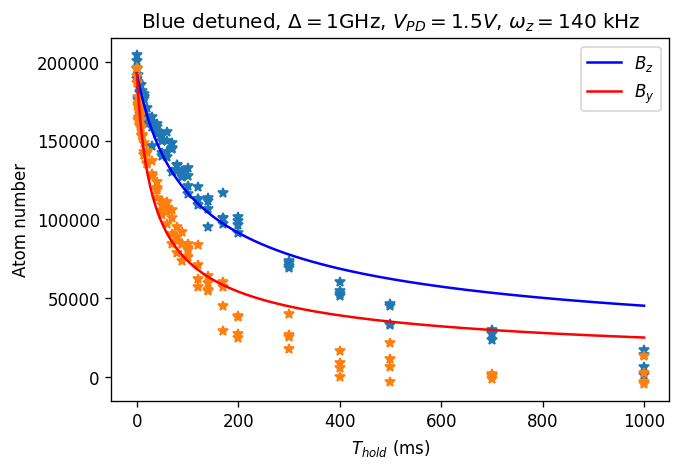

In [107]:
detuning = '1.5V'
TOF = 7
df_reduced_z = getReducedDataframe(df, detuning,'Bz', TOF)
df_reduced_y = getReducedDataframe(df, detuning,'By', TOF)
result_reduced_z = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
result_reduced_y = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)

dNdt = dN_polarized_pure3b_dt(dt, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0])
holdTime = np.linspace(0,1000, 300)
plt.figure(dpi = 120)
plt.plot(df_reduced_z['BECHoldTime'], df_reduced_z['nCount'], '*')
plt.plot(df_reduced_y['BECHoldTime'], df_reduced_y['nCount'], '*')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]), color = 'blue', label = '$B_{z}$')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_y['N0'].iloc[0], result_reduced_y['gamma'].iloc[0]), color = 'red', label = '$B_{y}$')
plt.title('Blue detuned, $\Delta = 1$GHz, $V_{PD} = 1.5V$, $\omega_{z} = 140$ kHz')
plt.legend()
plt.xlabel('$T_{hold}$ (ms)')
plt.ylabel('Atom number')
plt.show()

In [108]:
resultsDF_pure3b

,detuning,TOF,field_direction,N0,gamma
0,1.5V,7,Bz,192757.300155,4.617410e-13
1,1.5V,7,By,192724.781136,1.568246e-12


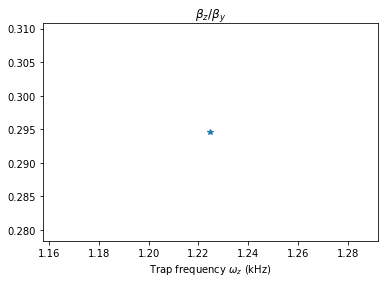

In [109]:
points15V = results_betaRatio[results_betaRatio['detuning'] == '1.5V']['betaRatio']
ratios = [points15V]
plt.figure()
plt.plot(np.sqrt(np.array([1.5])), ratios, '*')
plt.title(r'$\beta_{z}/\beta_{y}$')
plt.xlabel(r'Trap frequency $\omega_{z}$ (kHz)')
plt.show()

In [32]:
results_betaRatio

,detuning,TOF,betaRatio
0,1.5V,7,0.294581


It doesn't look good at all, it should be reversed, the $\beta_{z}$ should be equal to $\beta_{y}$ for small $\omega_{z}$ and drop at the threshold.

1.5V 7


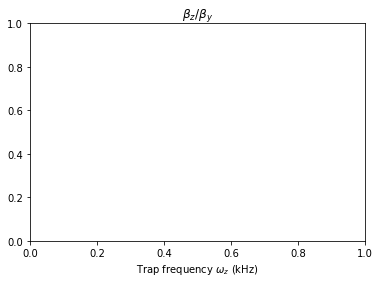

In [40]:
def dN_polarized_pure3b_dt(t, N0, gamma):
    return -0.5*N0**3*gamma*(1+N0**2*gamma*t)**(-3/2)

def getBeta(results, detuning, field_direction, TOF):
    temp = results[results['detuning'] == detuning]
    temp = temp[temp['TOF'] == TOF]
    return temp[temp['field_direction'] == field_direction]['gamma']

results_betaRatio = []
for detuning in ['1.5V']:#, '1.5GHz']:
    for TOF in [7]:#, 3]:
        print(detuning, TOF)
        beta_y_init = getBeta(resultsDF_pure3b, detuning, 'By', TOF)
        beta_z_init = getBeta(resultsDF_pure3b, detuning, 'Bz', TOF)
        dt = deltaTime(resultsDF_pure3b, detuning, TOF)
        
        results_By = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)
        results_Bz = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
        N0_y, gamma_y = results_By['N0'].iloc[0], results_By['gamma'].iloc[0]
        N0_z, gamma_z = results_Bz['N0'].iloc[0], results_Bz['gamma'].iloc[0]
        
        beta_y = dN_polarized_pure3b_dt(0, N0_y, gamma_y)
        beta_z = dN_polarized_pure3b_dt(0, N0_z, gamma_z)
        
        results_betaRatio += [{'detuning' : detuning,
                        'TOF' : TOF,
                        'betaRatio' : beta_z/beta_y}]

results_betaRatio = pd.DataFrame(results_betaRatio)

results_betaRatio

points05G = results_betaRatio[results_betaRatio['detuning'] == '0.5GHz']['betaRatio']
#points15G = results_betaRatio[results_betaRatio['detuning'] == '1.5GHz']['betaRatio']

plt.figure()
#plt.plot([116], points05G, '*')
#plt.plot([96], points15G, '*')
plt.title(r'$\beta_{z}/\beta_{y}$')
plt.xlabel(r'Trap frequency $\omega_{z}$ (kHz)')
plt.show()

<Figure size 432x288 with 0 Axes>

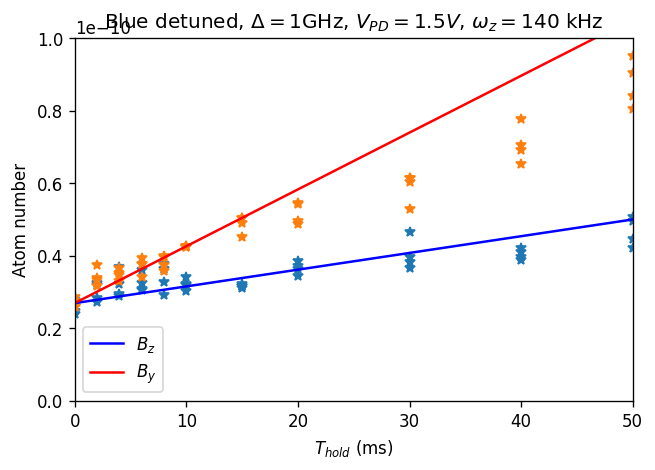

In [63]:
detunign = '1.5V'
TOF = 7
#from matplotlib.ticker import NullFormatter  # useful for `logit` scale


df_reduced_z = getReducedDataframe(df, detuning,'Bz', TOF)
df_reduced_z['nCount'] = np.abs(df_reduced_z['nCount'])
df_reduced_y = getReducedDataframe(df, detuning,'By', TOF)
df_reduced_y['nCount'] = np.abs(df_reduced_y['nCount'])
result_reduced_z = getReducedResults(resultsDF_pure3b, detuning, 'Bz', TOF)
result_reduced_y = getReducedResults(resultsDF_pure3b, detuning, 'By', TOF)

plt.figure()
holdTime = np.linspace(0, 1000, 300)
plt.figure(dpi = 120)
plt.plot(df_reduced_z['BECHoldTime'], df_reduced_z['nCount']**(-2), '*')
plt.plot(df_reduced_y['BECHoldTime'], df_reduced_y['nCount']**(-2), '*')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0])**(-2), color = 'blue', label = '$B_{z}$')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_y['N0'].iloc[0], result_reduced_y['gamma'].iloc[0])**(-2), color = 'red', label = '$B_{y}$')
plt.title('Blue detuned, $\Delta = 1$GHz, $V_{PD} = 1.5V$, $\omega_{z} = 140$ kHz')
plt.legend()
#plt.yscale('log')
plt.ylim(0,1*10**(-10))
plt.xlim(0,50)
plt.xlabel('$T_{hold}$ (ms)')
plt.ylabel('Atom number')
plt.show()

In [36]:
result_reduced_z

,detuning,TOF,field_direction,N0,gamma


In [42]:
plt.figure()
holdTime = np.linspace(0, 1000, 300)
plt.figure(dpi = 120)
plt.plot(holdTime, 1), color = 'red', label = '$B_{y}$')
plt.title('Blue detuned, $\Delta = 1$GHz, $V_{PD} = 1.5V$, $\omega_{z} = 140$ kHz')
plt.legend()
plt.yscale('log')
plt.xlim(0,500)
plt.xlabel('$T_{hold}$ (ms)')
plt.ylabel('Atom number')
plt.show()

,imageID,BECHoldTime,TOF,nCount,detuning,field_direction
0,97472.0,20.0,7,160894.0,1.5V,Bz
1,97473.0,8.0,7,185303.0,1.5V,Bz
2,97474.0,15.0,7,177657.0,1.5V,Bz
3,97475.0,170.0,7,116548.0,1.5V,Bz
4,97476.0,700.0,7,29780.0,1.5V,Bz
...,...,...,...,...,...,...
95,97567.0,4.0,7,176264.0,1.5V,Bz
96,97568.0,400.0,7,51725.0,1.5V,Bz
97,97569.0,2.0,7,177127.0,1.5V,Bz
98,97570.0,10.0,7,171212.0,1.5V,Bz


<Figure size 432x288 with 0 Axes>

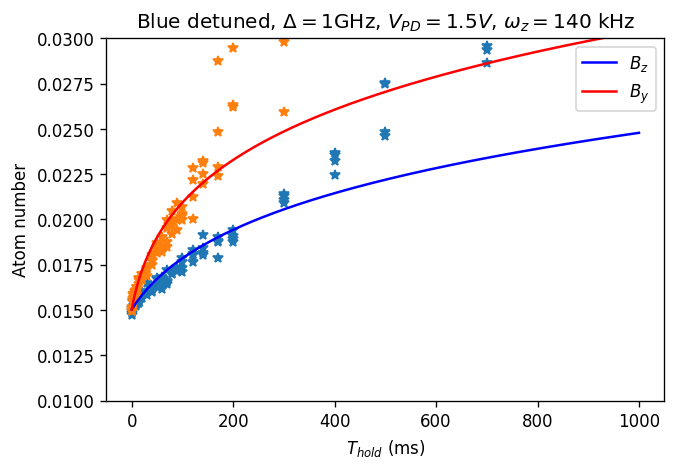

In [56]:
def powerlaw(t, N0, alpha, beta):
    return (N0**(-(beta-1))+(beta-1)*alpha*t)**(-1/(beta-1))

def fit_powerlaw(df, detuning = '1GHz', field_direction = 'Bz', TOF = 3):
    df_reduced = getReducedDataframe(df, detuning, field_direction, TOF)
    N0_guess = max(df_reduced['nCount'])
    time_guess = max(df_reduced['BECHoldTime'])
    beta_guess = 3
    popt, pcov = curve_fit(powerlaw, df_reduced['BECHoldTime'], df_reduced['nCount'],
                       p0 = [N0_guess, 1/(N0_guess**2*time_guess), beta_guess],
                       method = 'lm'
                      )
    return popt, pcov

popt, pcov = fit_powerlaw(df, '1.5V', field_direction = 'By', TOF = 7)
N0, alpha, beta = popt

plt.figure()
holdTime = np.linspace(0, 1000, 300)
plt.figure(dpi = 120)
plt.plot(df_reduced_z['BECHoldTime'], df_reduced_z['nCount']**(-(beta-1)), '*')
plt.plot(df_reduced_y['BECHoldTime'], df_reduced_y['nCount']**(-(beta-1)), '*')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0])**(-(beta-1)), color = 'blue', label = '$B_{z}$')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_y['N0'].iloc[0], result_reduced_y['gamma'].iloc[0])**(-(beta-1)), color = 'red', label = '$B_{y}$')
plt.title('Blue detuned, $\Delta = 1$GHz, $V_{PD} = 1.5V$, $\omega_{z} = 140$ kHz')
plt.legend()
#plt.yscale('log')
plt.ylim(0.01,0.3*10**(-1))
#plt.xlim(0,50)
plt.xlabel('$T_{hold}$ (ms)')
plt.ylabel('Atom number')
plt.show()

<Figure size 432x288 with 0 Axes>

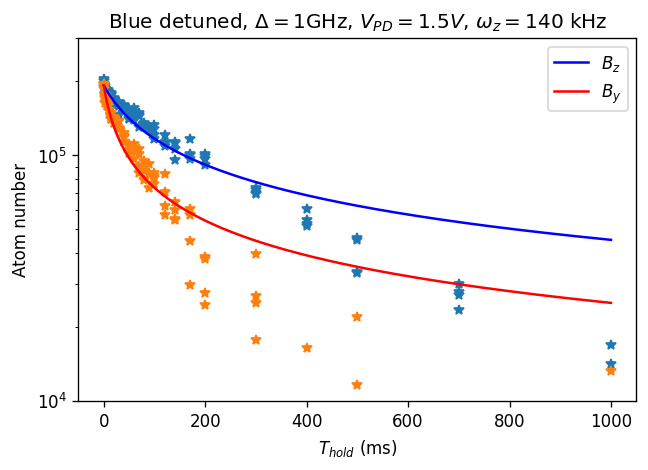

In [61]:
plt.figure()
holdTime = np.linspace(0, 1000, 300)
plt.figure(dpi = 120)
plt.plot(df_reduced_z['BECHoldTime'], df_reduced_z['nCount'], '*')
plt.plot(df_reduced_y['BECHoldTime'], df_reduced_y['nCount'], '*')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_z['N0'].iloc[0], result_reduced_z['gamma'].iloc[0]), color = 'blue', label = '$B_{z}$')
plt.plot(holdTime, N_polarized_pure3b(holdTime, result_reduced_y['N0'].iloc[0], result_reduced_y['gamma'].iloc[0]), color = 'red', label = '$B_{y}$')
plt.title('Blue detuned, $\Delta = 1$GHz, $V_{PD} = 1.5V$, $\omega_{z} = 140$ kHz')
plt.legend()
plt.yscale('log')
plt.ylim(10**4,3*10**5)
#plt.xlim(0,50)
plt.xlabel('$T_{hold}$ (ms)')
plt.ylabel('Atom number')
plt.show()

<Figure size 432x288 with 0 Axes>

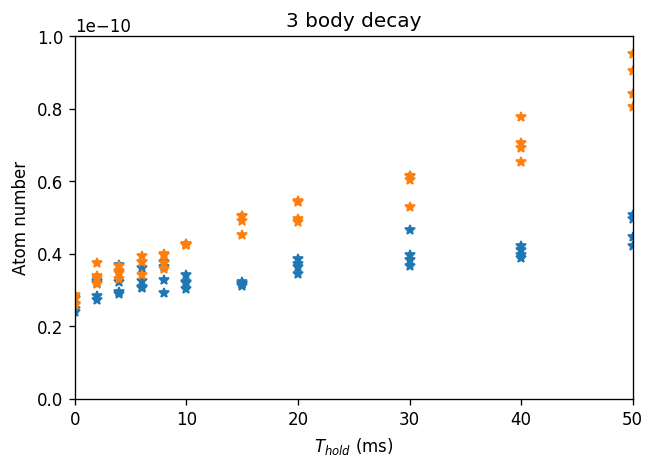

<Figure size 432x288 with 0 Axes>

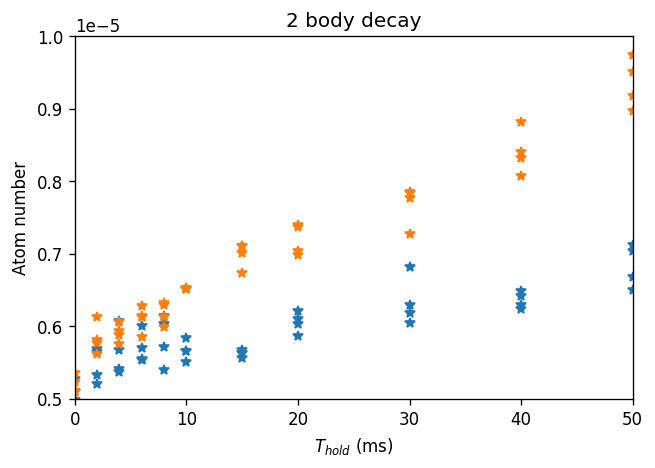

<Figure size 432x288 with 0 Axes>

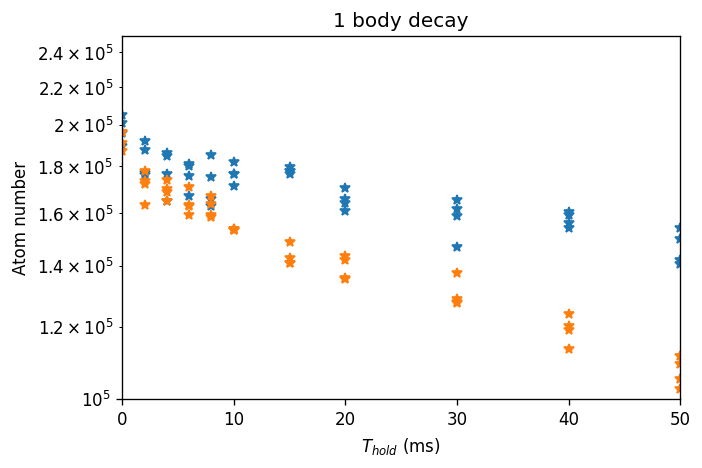

<Figure size 432x288 with 0 Axes>

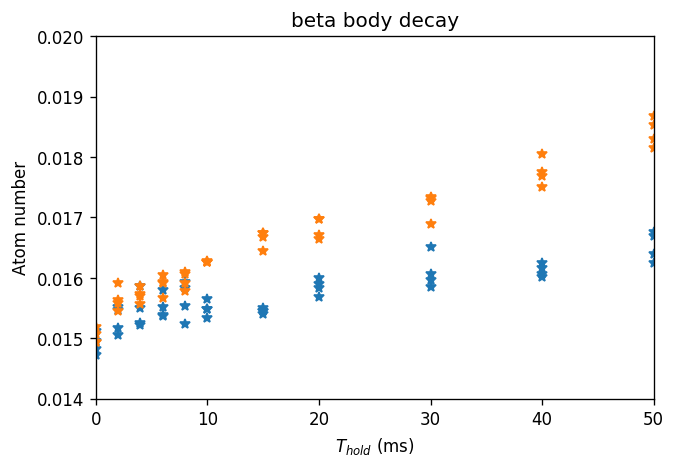

In [93]:
plt.figure()
holdTime = np.linspace(0, 1000, 300)
plt.figure(dpi = 120)
plt.plot(df_reduced_z['BECHoldTime'], df_reduced_z['nCount']**(-2), '*')
plt.plot(df_reduced_y['BECHoldTime'], df_reduced_y['nCount']**(-2), '*')
plt.title('3 body decay')
#plt.yscale('log')
plt.ylim(0,1*10**(-10))
plt.xlim(0,50)
plt.xlabel('$T_{hold}$ (ms)')
plt.ylabel('Atom number')
plt.show()


plt.figure()
holdTime = np.linspace(0, 1000, 300)
plt.figure(dpi = 120)
plt.plot(df_reduced_z['BECHoldTime'], df_reduced_z['nCount']**(-1), '*')
plt.plot(df_reduced_y['BECHoldTime'], df_reduced_y['nCount']**(-1), '*')
plt.title('2 body decay')
#plt.yscale('log')
plt.ylim(0.5*10**(-5),1*10**(-5))
plt.xlim(0,50)
plt.xlabel('$T_{hold}$ (ms)')
plt.ylabel('Atom number')
plt.show()


plt.figure()
holdTime = np.linspace(0, 1000, 300)
plt.figure(dpi = 120)
plt.plot(df_reduced_z['BECHoldTime'], df_reduced_z['nCount'], '*')
plt.plot(df_reduced_y['BECHoldTime'], df_reduced_y['nCount'], '*')
plt.title('1 body decay')
plt.yscale('log')
plt.ylim(10**5,2.5*10**(5))
plt.xlim(0,50)
plt.xlabel('$T_{hold}$ (ms)')
plt.ylabel('Atom number')
plt.show()


plt.figure()
holdTime = np.linspace(0, 1000, 300)
plt.figure(dpi = 120)
plt.plot(df_reduced_z['BECHoldTime'], df_reduced_z['nCount']**(-(beta-1)), '*')
plt.plot(df_reduced_y['BECHoldTime'], df_reduced_y['nCount']**(-(beta-1)), '*')
plt.title('beta body decay')
#plt.yscale('log')
plt.ylim(0.014,0.02)
plt.xlim(0,50)
plt.xlabel('$T_{hold}$ (ms)')
plt.ylabel('Atom number')
plt.show()

<Figure size 432x288 with 0 Axes>

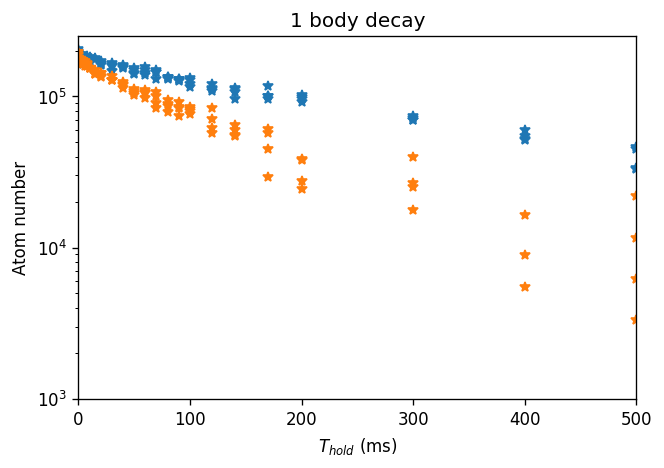

In [96]:
plt.figure()
holdTime = np.linspace(0, 1000, 300)
plt.figure(dpi = 120)
plt.plot(df_reduced_z['BECHoldTime'], df_reduced_z['nCount'], '*')
plt.plot(df_reduced_y['BECHoldTime'], df_reduced_y['nCount'], '*')
plt.title('1 body decay')
plt.yscale('log')
plt.ylim(10**3,2.5*10**(5))
plt.xlim(0,500)
plt.xlabel('$T_{hold}$ (ms)')
plt.ylabel('Atom number')
plt.show()